
# **Project 1 (1223239758): Gradient-based Algorithms and Differentiable Programming**
**1. Introduction** \\
Consider a simple formulation of rocket landing where the rocket state $x(t)$ is represented by its distance to the ground $d(t)$ and its velocity $v(t)$, i.e., $x(t) = [d(t), v(t)]^T$, where $t$ specifies time. The control input of the rocket is its acceleration $a(t)$. The discrete-time dynamics follows

$$
\begin{aligned}
d(t+1) = d(t) + v(t) \Delta t, \\
v(t+1) = v(t) + a(t) \Delta t,
\end{aligned}
$$
where $\Delta t$ is a time interval. Further, let the closed-loop controller be

$$
a(t) = f_{\theta}(x(t))
$$
where $f_{\theta}(\cdot)$ is a neural network with parameters $\theta$, which are to be determined through optimization.

For each time step, we assign a loss as a function of the control input and the state: $l(x(t),a(t))$. In this example, we will simply set $l(x(t),a(t))=0$ for all $t=1,...,T-1$, where $T$ is the final time step, and $l(x(T),a(T)) = ||x(T)||^2 = d(T)^2 + v(T)^2$. This loss encourages the rocket to reach $d(T)=0$ and $v(T)=0$, which are proper landing conditions.

The optimization problem is now formulated as

$$
\begin{aligned}
\min_{\theta} \quad ||x(T)||^2 \\
\quad        d(t+1) = d(t) + v(t) \Delta t, \\
\quad       v(t+1) = v(t) + a(t) \Delta t, \\
\quad       a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1
\end{aligned}
$$
While this problem is constrained, it is easy to see that the objective function can be expressed as a function of $x(T-1) and a(T-1)$, where $x(T-1)$ as a function of $x(T-2)$ and $a(T-2)$, and so on. Thus it is essentially an unconstrained problem with respect to $\theta$.

In the following, we code this problem up with PyTorch, which allows us to only build the forward pass of the loss (i.e., how we move from $x(1)$ to $x(2)$ and all the way to $x(T)$) and automatically get the gradient $\nabla_{\theta} l(x(T),a(T))$

##**2-**Defining the **Objective function** 
##**3-Variables**  
##**4-Constraints**  
##**5-Assumptions** involved in formulating the problem.

In [2]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt


logger = logging.getLogger(__name__)

In [65]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 9.81  # gravity constant
BOOST_ACCEL = 12  # thrust constant
ROTATION_ACCEL = 20  # rotation constant
OTHER_SIDE_BOOST_ACCEL= 0.2 #newly added
# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height


In [23]:
#define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """
        
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... 
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME])

        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        delta_state_gravity = t.tensor([0., -GRAVITY_ACCEL * FRAME_TIME, 0, 0]) # (newly added)
        delta_state = BOOST_ACCEL * FRAME_TIME * t.tensor([0., 1., 0., 0.]) * action[1]
        
        #updating rotation
        delta_state_rotation = t.tensor([0., 0, 0, ROTATION_ACCEL* FRAME_TIME]) # (newly added)
        
        # Updating velocity
        delta_state_angular = OTHER_SIDE_BOOST_ACCEL * FRAME_TIME * t.tensor([0., 0, 0, -1.]) * action[0] # (newly added)
       
        # Updating state
        state = state + delta_state + delta_state_gravity + delta_state_rotation + delta_state_angular # (newly added)

        step_mat = t.tensor([[1., FRAME_TIME, 0., 0.], 
                            [0., 1., 0., 0.],
                            [0., 0., 1., FRAME_TIME],
                            [0., 0., 0., 1.]])
        
        state = t.matmul(step_mat, state)

        return state

In [18]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [20]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [20., 0., 2., 0.]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2

In [63]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        
        fig=plt.figure(figsize=(8,8))
        x = data[:, 0]
        y = data[:, 1] 
        plt.subplot(1,2,1)
        plt.axes(projection ='3d')    
        plt.title('Distance & Velocity')
        plt.xlabel('X_Distance')
        plt.ylabel('X_Velocity')       
        plt.plot(x, y, color='indigo')
        plt.show()       

        fig=plt.figure(figsize=(6,6))
        plt.subplot(1,2,2)
        plt.axes(projection ='3d')
        theta_angle = data[:, 2]
        angular_velocity = data[:, 3]
        plt.title('Theta_angle & angular_velocity') 
        plt.plot(theta_angle, angular_velocity, color='darkgreen')
        plt.xlabel("theta_angle")
        plt.ylabel("angular velocity")
        plt.tight_layout()
        plt.show()


[1] loss: 878.368


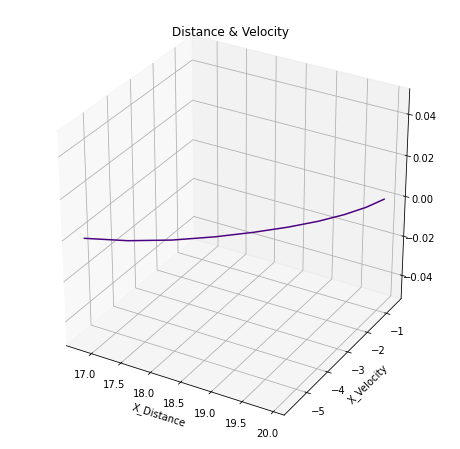

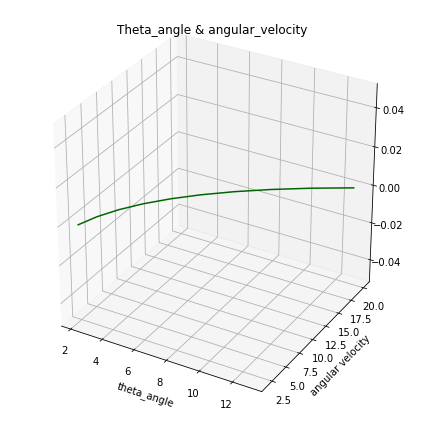

[2] loss: 861.589


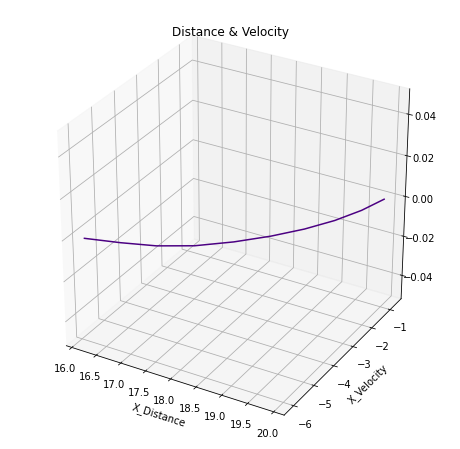

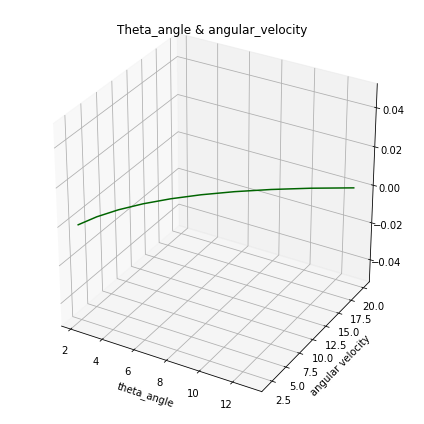

[3] loss: 832.443


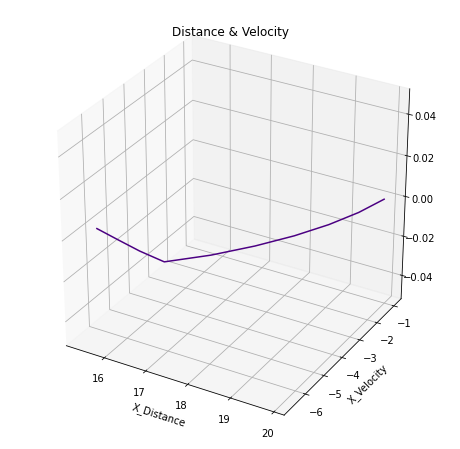

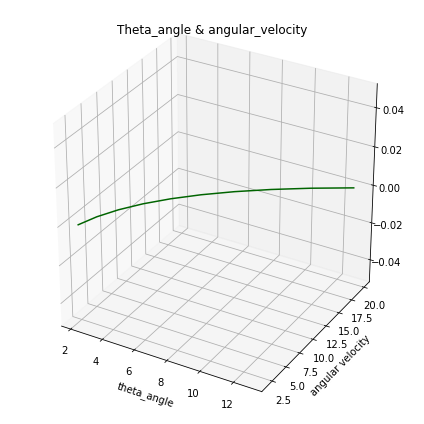

[4] loss: 832.292


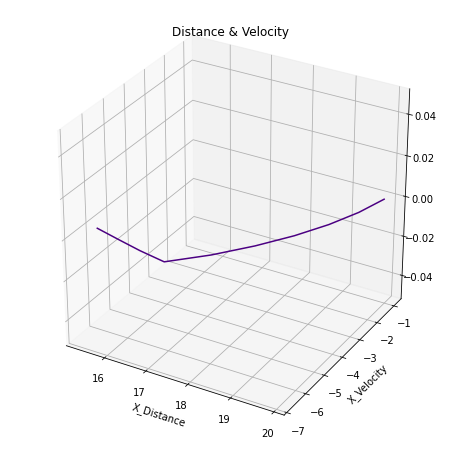

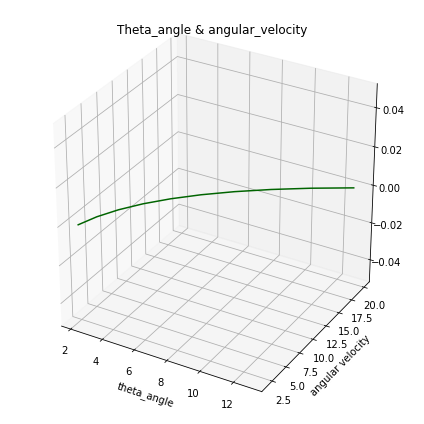

[5] loss: 832.160


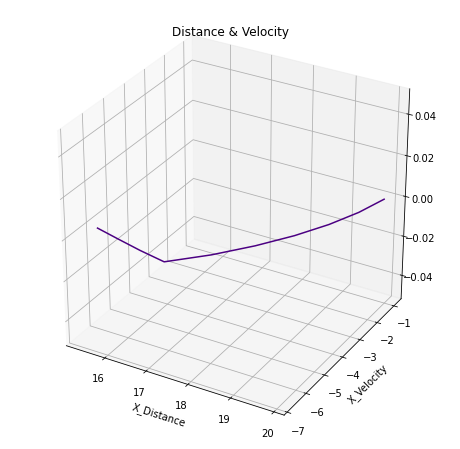

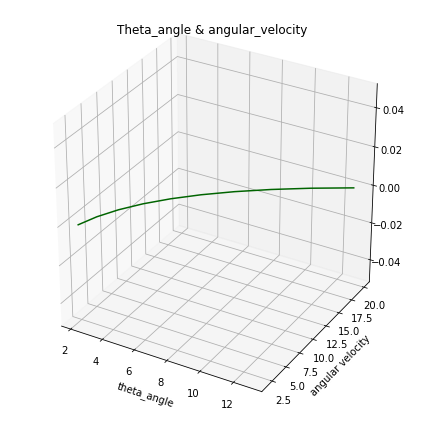

[6] loss: 832.054


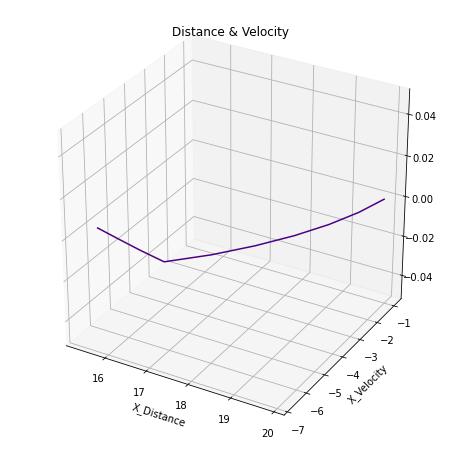

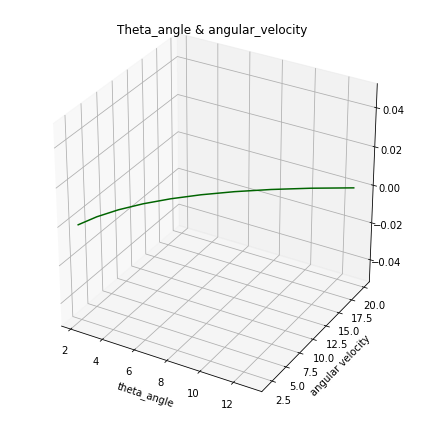

[7] loss: 831.969


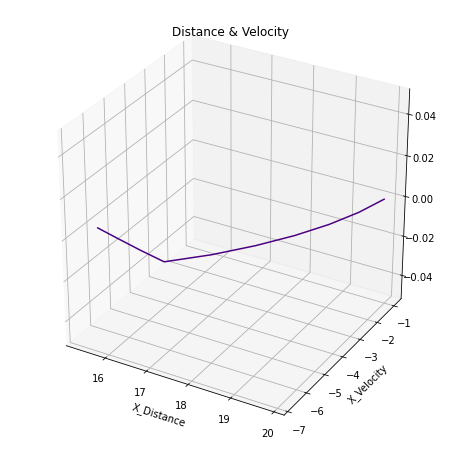

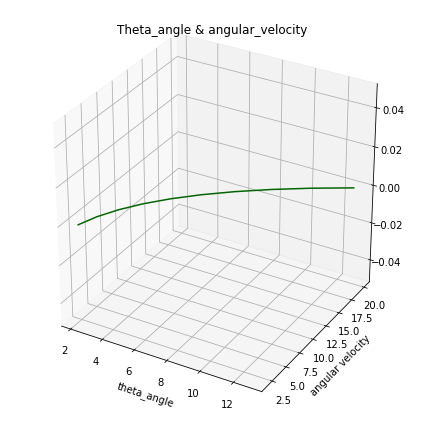

[8] loss: 831.900


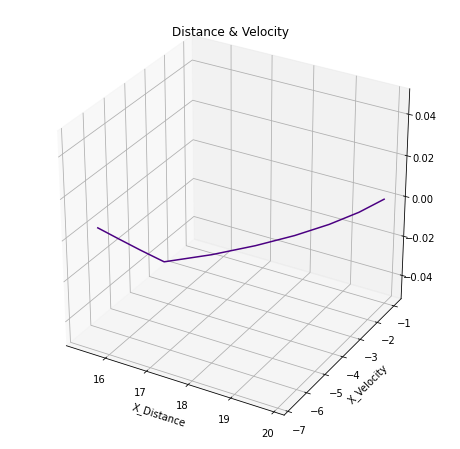

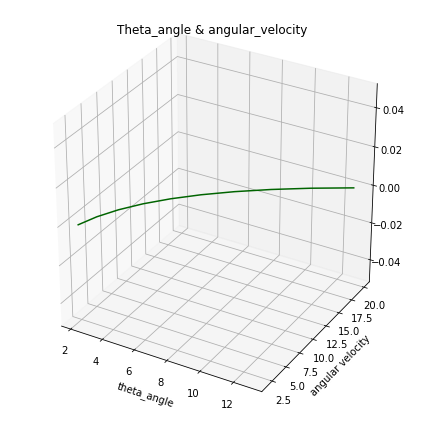

[9] loss: 831.843


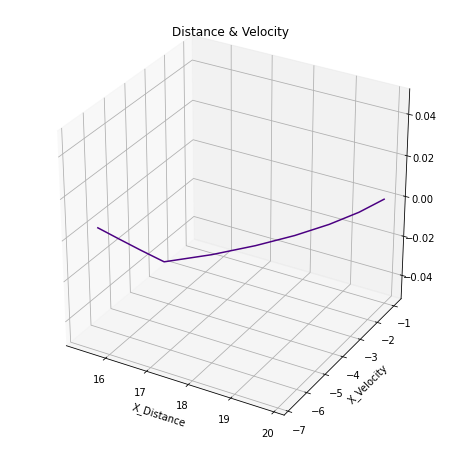

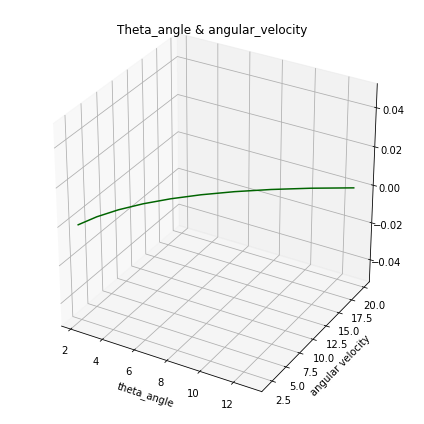

[10] loss: 831.798


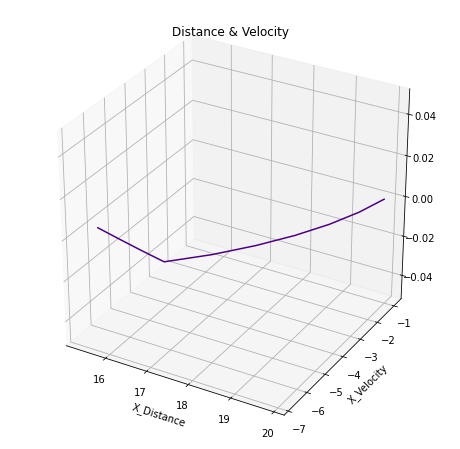

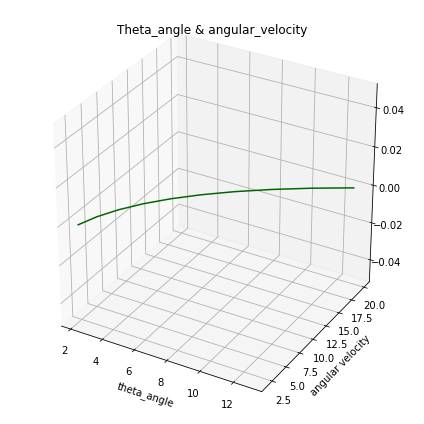

In [64]:
# Now it's time to run the code!

T = 10  # number of time steps
dim_input = 4 # state space dimensions
dim_hidden = 12  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(10)  # solve the optimization problem